## Hands On Binary Customer Churn Evaluator

A marketing agency has many customers that use their service to produce ads for the client/customer websites. They've noticed that they have quite a bit of churn in clients. They basically randomly assign account managers right now, but want you to create a machine learning model that will help predict which customers will churn (stop buying their service) so that they can correctly assign the customers most at risk to churn an account manager. Luckily they have some historical data, can you help them out? Create a classification algorithm that will help classify whether or not a customer churned. Then the company can test this against incoming data for future customers to predict which customers will churn and assign them an account manager.

The data is saved as customer_churn.csv. Here are the fields and their definitions:

    Name : Name of the latest contact at Company
    Age: Customer Age
    Total_Purchase: Total Ads Purchased
    Account_Manager: Binary 0=No manager, 1= Account manager assigned
    Years: Totaly Years as a customer
    Num_sites: Number of websites that use the service.
    Onboard_date: Date that the name of the latest contact was onboarded
    Location: Client HQ Address
    Company: Name of Client Company
    
Once you've created the model and evaluated it, test out the model on some new data (you can think of this almost like a hold-out set) that your client has provided, saved under new_customers.csv. The client wants to know which customers are most likely to churn given this data (they don't have the label yet).

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Churn').getOrCreate()

In [2]:
from pyspark.ml.classification import LogisticRegression

In [3]:
df = spark.read.csv('customer_churn.csv',inferSchema=True,header=True)

In [4]:
df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: integer (nullable = true)
 |-- Onboard_date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [5]:
df.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn']

In [6]:
from pyspark.ml.feature import VectorAssembler

In [7]:
assembler = VectorAssembler(inputCols=['Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites'],outputCol='features')

In [8]:
output = assembler.transform(df)

In [9]:
final_data = output.select('features','churn')

In [10]:
final_data.show()

+--------------------+-----+
|            features|churn|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
|[30.0,11575.37,1....|    1|
|[45.0,8771.02,1.0...|    1|
|[45.0,8988.67,1.0...|    1|
|[40.0,8283.32,1.0...|    1|
|[41.0,6569.87,1.0...|    1|
|[38.0,10494.82,1....|    1|
|[45.0,8213.41,1.0...|    1|
|[43.0,11226.88,0....|    1|
|[53.0,5515.09,0.0...|    1|
|[46.0,8046.4,1.0,...|    1|
+--------------------+-----+
only showing top 20 rows



In [11]:
train_churn,test_churn = final_data.randomSplit([0.7,0.3])

In [12]:
lr_churn = LogisticRegression(featuresCol = 'features',labelCol='churn')

In [13]:
fitted_churn_model = lr_churn.fit(train_churn)

In [14]:
training_sum = fitted_churn_model.summary

### Evaluate results

Let's evaluate the results on the data set we were given (using the test data)

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [16]:
pred_and_labels = fitted_churn_model.evaluate(test_churn)

In [17]:
pred_and_labels.predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|churn|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[22.0,11254.38,1....|    0|[5.52159691806313...|[0.99601647589334...|       0.0|
|[28.0,9090.43,1.0...|    0|[1.98633570663306...|[0.87935493331968...|       0.0|
|[28.0,11245.38,0....|    0|[4.30633075424808...|[0.9866964398551,...|       0.0|
|[29.0,5900.78,1.0...|    0|[4.96690245369377...|[0.99308348328094...|       0.0|
|[29.0,8688.17,1.0...|    1|[3.29103080746525...|[0.96411982968159...|       0.0|
|[29.0,9617.59,0.0...|    0|[5.09436401487799...|[0.99390615784382...|       0.0|
|[29.0,10203.18,1....|    0|[4.42382577320060...|[0.98815373632693...|       0.0|
|[29.0,11274.46,1....|    0|[5.16168197118429...|[0.99430061871156...|       0.0|
|[30.0,8403.78,1.0...|    0|[6.84447297381239...|[0.99893580617074...|       0.0|
|[30.0,8677.28,1

### Using AUC

In [18]:
churn_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                           labelCol='churn')

In [19]:
auc = churn_eval.evaluate(pred_and_labels.predictions)

In [20]:
auc

0.7764291670527194

In [21]:
type(pred_and_labels)

pyspark.ml.classification.BinaryLogisticRegressionSummary

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

In [23]:
test_lr_model = fitted_churn_model.transform(test_churn)

In [24]:
test_lr_model.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|churn|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[22.0,11254.38,1....|    0|[5.52159691806313...|[0.99601647589334...|       0.0|
|[28.0,9090.43,1.0...|    0|[1.98633570663306...|[0.87935493331968...|       0.0|
|[28.0,11245.38,0....|    0|[4.30633075424808...|[0.9866964398551,...|       0.0|
|[29.0,5900.78,1.0...|    0|[4.96690245369377...|[0.99308348328094...|       0.0|
|[29.0,8688.17,1.0...|    1|[3.29103080746525...|[0.96411982968159...|       0.0|
|[29.0,9617.59,0.0...|    0|[5.09436401487799...|[0.99390615784382...|       0.0|
|[29.0,10203.18,1....|    0|[4.42382577320060...|[0.98815373632693...|       0.0|
|[29.0,11274.46,1....|    0|[5.16168197118429...|[0.99430061871156...|       0.0|
|[30.0,8403.78,1.0...|    0|[6.84447297381239...|[0.99893580617074...|       0.0|
|[30.0,8677.28,1

In [25]:
type(test_lr_model)

pyspark.sql.dataframe.DataFrame

In [26]:
dfg = test_lr_model.toPandas()

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
import pandas as pd

In [28]:
import numpy as np

In [29]:
type(dfg)

pandas.core.frame.DataFrame

In [30]:
AUROC = roc_auc_score(dfg['churn'],dfg['prediction'])

In [31]:
AUROC

0.7764291670527194

In [32]:
dfg.head(10)

,features,churn,rawPrediction,probability,prediction
0,"[22.0, 11254.38, 1.0, 4.96, 8.0]",0,"[5.521596918063132, -5.521596918063132]","[0.9960164758933467, 0.0039835241066532405]",0.0
1,"[28.0, 9090.43, 1.0, 5.74, 10.0]",0,"[1.9863357066330636, -1.9863357066330636]","[0.8793549333196816, 0.12064506668031845]",0.0
2,"[28.0, 11245.38, 0.0, 6.72, 8.0]",0,"[4.30633075424808, -4.30633075424808]","[0.9866964398551, 0.013303560144900025]",0.0
3,"[29.0, 5900.78, 1.0, 5.56, 8.0]",0,"[4.966902453693777, -4.966902453693777]","[0.993083483280944, 0.006916516719056102]",0.0
4,"[29.0, 8688.17, 1.0, 5.7, 9.0]",1,"[3.2910308074652583, -3.2910308074652583]","[0.9641198296815964, 0.035880170318403674]",0.0
5,"[29.0, 9617.59, 0.0, 5.49, 8.0]",0,"[5.094364014877996, -5.094364014877996]","[0.9939061578438267, 0.006093842156173179]",0.0
6,"[29.0, 10203.18, 1.0, 5.82, 8.0]",0,"[4.423825773200608, -4.423825773200608]","[0.9881537363269345, 0.011846263673065542]",0.0
7,"[29.0, 11274.46, 1.0, 4.43, 8.0]",0,"[5.16168197118429, -5.16168197118429]","[0.9943006187115672, 0.005699381288432765]",0.0
8,"[30.0, 8403.78, 1.0, 4.13, 7.0]",0,"[6.844472973812392, -6.844472973812392]","[0.9989358061707416, 0.0010641938292584945]",0.0
9,"[30.0, 8677.28, 1.0, 7.31, 7.0]",0,"[4.911352085561905, -4.911352085561905]","[0.9926912837869708, 0.007308716213029219]",0.0


In [46]:
dfg.describe()

,churn,prediction
count,294.000000,294.000000
mean,0.146259,0.132653
std,0.353968,0.339778
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [49]:
a=[]
for i in range(294):
    a.append(dfg['probability'][i][1])

In [53]:
dft = pd.DataFrame(a)

In [55]:
dft.columns = ['Probability of not churn']

In [56]:
dft.head(10)

,Probability of not churn
0,0.003984
1,0.120645
2,0.013304
3,0.006917
4,0.035880
5,0.006094
6,0.011846
7,0.005699
8,0.001064
9,0.007309


In [57]:
fpr,tpr,thresholds = roc_curve(dfg['churn'],dft['Probability of not churn'])

Text(0.5, 1.0, 'ROC Curve')

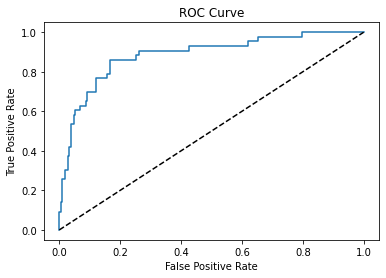

In [58]:
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,linestyle='--',color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [39]:
from sklearn.metrics import plot_confusion_matrix

In [42]:
dfg.head(10)

,features,churn,rawPrediction,probability,prediction
0,"[25.0, 9672.03, 0.0, 5.49, 8.0]",0,"[5.058411246307447, -5.058411246307447]","[0.9936844901076958, 0.006315509892304134]",0.0
1,"[26.0, 8939.61, 0.0, 4.54, 7.0]",0,"[6.91156995401764, -6.91156995401764]","[0.9990047988204478, 0.0009952011795522138]",0.0
2,"[29.0, 11274.46, 1.0, 4.43, 8.0]",0,"[4.5384903283838725, -4.5384903283838725]","[0.9894235255017542, 0.010576474498245805]",0.0
3,"[29.0, 13255.05, 1.0, 4.89, 8.0]",0,"[4.121378406981179, -4.121378406981179]","[0.984036818621191, 0.01596318137880903]",0.0
4,"[30.0, 8403.78, 1.0, 4.13, 7.0]",0,"[6.220715534045645, -6.220715534045645]","[0.998016121244835, 0.0019838787551648912]",0.0
5,"[30.0, 10183.98, 1.0, 5.14, 9.0]",0,"[2.8533233218640888, -2.8533233218640888]","[0.9454902154988308, 0.05450978450116926]",0.0
6,"[30.0, 10960.52, 1.0, 5.96, 9.0]",0,"[2.34321738025276, -2.34321738025276]","[0.912393596720317, 0.08760640327968308]",0.0
7,"[30.0, 12788.37, 0.0, 4.31, 10.0]",0,"[2.4729410654229937, -2.4729410654229937]","[0.922222983019071, 0.077777016980929]",0.0
8,"[30.0, 13473.35, 0.0, 3.84, 10.0]",0,"[2.6695317343018417, -2.6695317343018417]","[0.935204661724413, 0.06479533827558702]",0.0
9,"[31.0, 5304.6, 0.0, 5.29, 9.0]",0,"[3.8526638669261573, -3.8526638669261573]","[0.9792179348879895, 0.020782065112010563]",0.0


In [47]:
from sklearn import metrics

In [50]:
import pandas as pd

In [48]:
cnf_matrix = metrics.confusion_matrix(dfg['churn'], dfg['prediction'])

Text(0.5, 257.44, 'Predicted label')

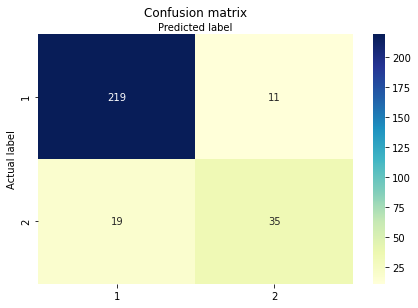

In [51]:
class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Predict on brand new unlabeled data

We still need to evaluate the new_customers.csv file!

In [24]:
final_lr_model = lr_churn.fit(final_data)

In [25]:
new_customers = spark.read.csv('new_customers.csv',inferSchema=True,
                              header=True)

In [26]:
new_customers.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)



In [27]:
test_new_customers = assembler.transform(new_customers)

In [28]:
test_new_customers.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- features: vector (nullable = true)



In [29]:
final_results = final_lr_model.transform(test_new_customers)

In [30]:
final_results.select('Company','prediction').show()

+----------------+----------+
|         Company|prediction|
+----------------+----------+
|        King Ltd|       0.0|
|   Cannon-Benson|       1.0|
|Barron-Robertson|       1.0|
|   Sexton-Golden|       1.0|
|        Wood LLC|       0.0|
|   Parks-Robbins|       1.0|
+----------------+----------+



Ok! That is it! Now we know that we should assign Acocunt Managers to Cannon-Benson,Barron-Robertson,Sexton-GOlden, and Parks-Robbins!